In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F

**Load data**

In [3]:
test_file = "./data/nyu2_test.csv"
train_file = "./data/nyu2_train.csv"

In [4]:
df_train = pd.read_csv(train_file, names=["img", "depth"], header=None)
df_test = pd.read_csv(test_file, names=["img", "depth"], header=None)

In [5]:
df_train.head()

50688

In [35]:
df_test.head()

,img,depth
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png


**Visualize example data**

In [36]:
def visualize_example(img_path, depth_path):
    img = Image.open(img_path)
    depth = Image.open(depth_path)

    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    axes[0].imshow(img)
    axes[0].set_title("Image")

    axes[1].imshow(depth)
    axes[1].set_title("Depth")

    # hide the axis ticks
    for ax in axes:
        ax.axis('off')

    plt.show()

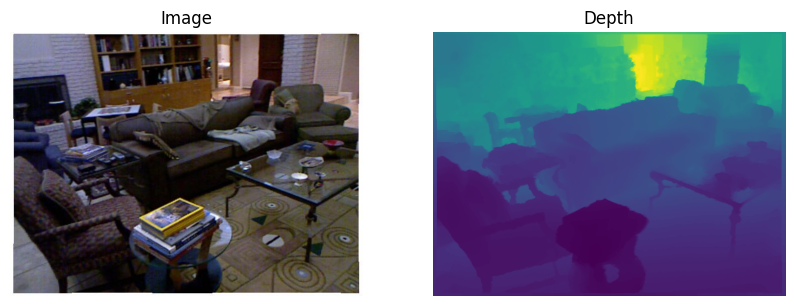

In [37]:
img_path = df_train.iloc[0]["img"]
depth_path = df_train.iloc[0]["depth"]

visualize_example(img_path, depth_path)

In [38]:
img = Image.open(img_path).convert("RGB")
np.array(img).shape

(480, 640, 3)

**Check mask values**

In [42]:
train_mask = Image.open(df_train.iloc[0]["depth"])
train_mask = np.asarray(train_mask, np.int32)

In [71]:
train_mask

array([[124, 124, 124, ..., 153, 153, 153],
       [124, 124, 124, ..., 153, 153, 153],
       [124, 124, 124, ..., 153, 153, 153],
       ...,
       [ 54,  54,  54, ...,  55,  56,  56],
       [ 54,  54,  54, ...,  55,  55,  55],
       [ 54,  54,  54, ...,  55,  55,  55]])

In [70]:
train_mask / 10_000

array([[0.0124, 0.0124, 0.0124, ..., 0.0153, 0.0153, 0.0153],
       [0.0124, 0.0124, 0.0124, ..., 0.0153, 0.0153, 0.0153],
       [0.0124, 0.0124, 0.0124, ..., 0.0153, 0.0153, 0.0153],
       ...,
       [0.0054, 0.0054, 0.0054, ..., 0.0055, 0.0056, 0.0056],
       [0.0054, 0.0054, 0.0054, ..., 0.0055, 0.0055, 0.0055],
       [0.0054, 0.0054, 0.0054, ..., 0.0055, 0.0055, 0.0055]])

In [75]:
def bilinear_interpolate(im, size):
    return F.interpolate(im, size=size, mode="bilinear", align_corners=True)

In [82]:
res = bilinear_interpolate(torch.tensor(train_mask).unsqueeze(0).unsqueeze(0).float(), size=(56, 56)).squeeze().numpy()

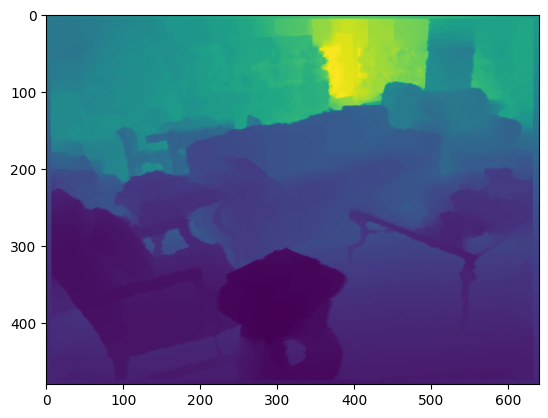

In [83]:
plt.imshow(train_mask)

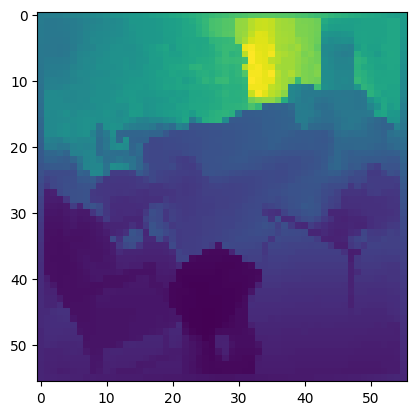

In [84]:
plt.imshow(res)

In [107]:
test_mask = Image.open(os.path.join("..", df_test.iloc[0]["depth"]))
test_mask = np.asarray(test_mask, np.int32)
test_mask

array([[2752, 2752, 2752, ..., 2242, 2242, 2242],
       [2751, 2752, 2752, ..., 2242, 2242, 2242],
       [2751, 2751, 2752, ..., 2242, 2242, 2242],
       ...,
       [2198, 2198, 2197, ..., 2081, 2081, 2080],
       [2197, 2197, 2197, ..., 2081, 2081, 2081],
       [2197, 2197, 2197, ..., 2081, 2081, 2081]])

**NYU Depth V2 Dataset**

In [59]:
class NYUDataset(Dataset):
    def __init__(self, df, data_dir, transform = None, target_transform = None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx, 0])
        mask_path = os.path.join(self.data_dir, self.df.iloc[idx, 1])

        img = np.asarray(Image.open(img_path))
        mask = np.asarray(Image.open(mask_path))

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        return img, mask

In [108]:
class NormalizeData(object):
    def __init__(self, divisor):
        self.divisor = divisor

    def __call__(self, img):
        return img / self.divisor

In [117]:
test_dataset = NYUDataset(df_test, "..", target_transform=NormalizeData(10_000))

In [118]:
next(iter(test_dataset))[1]

array([[0.2752, 0.2752, 0.2752, ..., 0.2242, 0.2242, 0.2242],
       [0.2751, 0.2752, 0.2752, ..., 0.2242, 0.2242, 0.2242],
       [0.2751, 0.2751, 0.2752, ..., 0.2242, 0.2242, 0.2242],
       ...,
       [0.2198, 0.2198, 0.2197, ..., 0.2081, 0.2081, 0.208 ],
       [0.2197, 0.2197, 0.2197, ..., 0.2081, 0.2081, 0.2081],
       [0.2197, 0.2197, 0.2197, ..., 0.2081, 0.2081, 0.2081]])